# PART 3 < 좌석 선호도 기반 클러스터링 >

# Import

In [1]:
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('data/concert_hall.csv')

In [3]:
concert = data.copy()

# Feature adding 

**Sell_delta** 
: tran_date - open_date 의 time delta 값으로, 얼마나 해당 좌석이 빨리 판매 되었는지를 설명

In [4]:
concert['tran_date'] = pd.to_datetime(concert['tran_date'],format = '%Y%m%d')
concert['open_date'] = pd.to_datetime(concert['open_date'],format = '%Y%m%d')

concert['sell_delta'] = (concert['tran_date'] - concert['open_date']).dt.days

**popularity** : seat_popularity + pre_popularity 
- seat_popularity : 해당 좌석 판매 빈도를 활용한 장르별 좌석 선호도 
- pre_popularity : 선예매 고객의 해당 좌석 판매 빈도를 활용한 장르별 좌석 선호도 ( 이를 활용하여 선예매된 좌석에 대한 가중을 줌 ) 

**popularity task 1** : 장르별 테이블 분할

In [5]:
# preprocessing - seat 복원 
concert['seat'] = concert['층'].apply(lambda x : str(x)+' ') + concert['블록(박스)'].apply(lambda x : str(x)+' ') + concert['열'].apply(lambda x : str(x)+' ') + concert['자리번호'].apply(lambda x : str(x)+' ')

concert['층'].replace('합창', '0', inplace=True) #층: 합창석 - 0으로 변환 : 추후 인코딩에 문제 없도록 
concert['층'] = concert['층'].astype(int)

In [6]:
# 원가 ori_price 

concert['discount']  = concert['discount_type'].str.extract(r'(\d{2})%', expand=False).fillna('0')
concert['ori_price'] = concert['price'] / (1 - (concert['discount'].astype('int')/100))
concert['ori_price'] = concert['ori_price'].astype('int')

In [7]:
# preprocessing - genre spliting (concert)

concert_교향곡 = concert[concert['genre']=='교향곡']
concert_독주 = concert[concert['genre']=='독주']
concert_클래식 = concert[concert['genre']=='클래식']
concert_오페라 = concert[concert['genre']=='오페라']
concert_합창 = concert[concert['genre']=='합창']
concert_성악 = concert[concert['genre']=='성악']
concert_실내악 = concert[concert['genre']=='실내악']
concert_콘서트 = concert[concert['genre']=='콘서트']
concert_재즈 = concert[concert['genre']=='재즈']
concert_크로스오버 = concert[concert['genre']=='크로스오버']
concert_가족극 = concert[concert['genre']=='가족극']

**popularity task 2** : 각 테이블 별 seat_popularity, pre_popularity 구현 및 popularity 칼럼 형성 

In [8]:
# seat_popularity 형성을 위한 함수 정의
def seat_popularity(df, column):
    frequency_map = df[column].value_counts().to_dict()
    df[column + '_popularity'] = df[column].map(frequency_map)
    return df.head()

In [9]:
# seat_popularity - concert 
seat_popularity(concert_교향곡, 'seat')
seat_popularity(concert_독주, 'seat')
seat_popularity(concert_클래식, 'seat')
seat_popularity(concert_오페라, 'seat')
seat_popularity(concert_합창, 'seat')
seat_popularity(concert_성악, 'seat')
seat_popularity(concert_실내악, 'seat')
seat_popularity(concert_콘서트, 'seat')
seat_popularity(concert_재즈, 'seat')
seat_popularity(concert_크로스오버, 'seat')
seat_popularity(concert_가족극, 'seat')

,Unnamed: 0,age,gender,membership_type_1,membership_type_2,membership_type_3,membership_type_4,membership_type_5,membership_type_6,tran_date,...,member_yn,층,자리번호,블록(박스),열,sell_delta,seat,discount,ori_price,seat_popularity
1285,2271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-25,...,N,1,2,C,10열,9,1 C 10열 2,0,0,3
5431,9609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-25,...,N,1,7,C,14열,9,1 C 14열 7,0,0,1
10432,18395,50.0,F,무료,NaN,NaN,NaN,NaN,NaN,2021-04-16,...,Y,1,2,C,22열,0,1 C 22열 2,50,100000,1
29258,51244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-26,...,N,1,11,C,15열,10,1 C 15열 11,0,0,1
31449,55005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-25,...,N,1,7,C,12열,9,1 C 12열 7,0,0,1


In [10]:
# pre_popularity 형성을 위한 함수 정의
def pre_popularity(df):
    frequency_map = df[df['sell_delta']<0].seat.value_counts().to_dict()
    df['pre_popularity'] = df['seat'].map(frequency_map).fillna(0)
    return df.head()

In [11]:
# pre_popularity - concert 
pre_popularity(concert_교향곡)
pre_popularity(concert_독주)
pre_popularity(concert_클래식)
pre_popularity(concert_오페라)
pre_popularity(concert_합창)
pre_popularity(concert_성악)
pre_popularity(concert_실내악)
pre_popularity(concert_콘서트)
pre_popularity(concert_재즈)
pre_popularity(concert_크로스오버)
pre_popularity(concert_가족극)

,Unnamed: 0,age,gender,membership_type_1,membership_type_2,membership_type_3,membership_type_4,membership_type_5,membership_type_6,tran_date,...,층,자리번호,블록(박스),열,sell_delta,seat,discount,ori_price,seat_popularity,pre_popularity
1285,2271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-25,...,1,2,C,10열,9,1 C 10열 2,0,0,3,0.0
5431,9609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-25,...,1,7,C,14열,9,1 C 14열 7,0,0,1,0.0
10432,18395,50.0,F,무료,NaN,NaN,NaN,NaN,NaN,2021-04-16,...,1,2,C,22열,0,1 C 22열 2,50,100000,1,0.0
29258,51244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-26,...,1,11,C,15열,10,1 C 15열 11,0,0,1,0.0
31449,55005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-25,...,1,7,C,12열,9,1 C 12열 7,0,0,1,0.0


In [12]:
# popularity 형성을 위한 함수 선언 
def popularity(df):
    df['popularity']=df['pre_popularity'] + df['seat_popularity']
    return df.head()

In [13]:
# popularity - concert
popularity(concert_교향곡)
popularity(concert_독주)
popularity(concert_클래식)
popularity(concert_오페라)
popularity(concert_합창)
popularity(concert_성악)
popularity(concert_실내악)
popularity(concert_콘서트)
popularity(concert_재즈)
popularity(concert_크로스오버)
popularity(concert_가족극)

,Unnamed: 0,age,gender,membership_type_1,membership_type_2,membership_type_3,membership_type_4,membership_type_5,membership_type_6,tran_date,...,자리번호,블록(박스),열,sell_delta,seat,discount,ori_price,seat_popularity,pre_popularity,popularity
1285,2271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-25,...,2,C,10열,9,1 C 10열 2,0,0,3,0.0,3.0
5431,9609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-25,...,7,C,14열,9,1 C 14열 7,0,0,1,0.0,1.0
10432,18395,50.0,F,무료,NaN,NaN,NaN,NaN,NaN,2021-04-16,...,2,C,22열,0,1 C 22열 2,50,100000,1,0.0,1.0
29258,51244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-26,...,11,C,15열,10,1 C 15열 11,0,0,1,0.0,1.0
31449,55005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-25,...,7,C,12열,9,1 C 12열 7,0,0,1,0.0,1.0


# Feature Selection for Clustering 

In [14]:
# cluster_query - concert  
concert_교향곡_ = concert_교향곡[['층','블록(박스)','열','자리번호','sell_delta','popularity']]
concert_독주_ = concert_독주[['층','블록(박스)','열','자리번호','sell_delta','popularity']]
concert_클래식_ = concert_클래식[['층','블록(박스)','열','자리번호','sell_delta','popularity']]
concert_오페라_ = concert_오페라[['층','블록(박스)','열','자리번호','sell_delta','popularity']]
concert_합창_ = concert_합창[['층','블록(박스)','열','자리번호','sell_delta','popularity']]
concert_성악_ = concert_성악[['층','블록(박스)','열','자리번호','sell_delta','popularity']]
concert_실내악_ = concert_실내악[['층','블록(박스)','열','자리번호','sell_delta','popularity']]
concert_콘서트_ = concert_콘서트[['층','블록(박스)','열','자리번호','sell_delta','popularity']]
concert_재즈_ = concert_재즈[['층','블록(박스)','열','자리번호','sell_delta','popularity']]
concert_크로스오버_ = concert_크로스오버[['층','블록(박스)','열','자리번호','sell_delta','popularity']]
concert_가족극_ = concert_가족극[['층','블록(박스)','열','자리번호','sell_delta','popularity']]

#### Encoding 

In [15]:
# cat & num spliting 
categorical_feats = ['블록(박스)','열']
numerical_feats = ['층','자리번호','sell_delta','popularity']

In [16]:
# label encoding for cat features using func.

encoder = LabelEncoder()
def labeling(df):
    for feat in categorical_feats:
        df[feat] = encoder.fit_transform(df[feat])
        
# labeling - concert
labeling(concert_교향곡_)
labeling(concert_독주_)
labeling(concert_클래식_)
labeling(concert_오페라_)
labeling(concert_합창_)
labeling(concert_성악_)
labeling(concert_실내악_)
labeling(concert_콘서트_)
labeling(concert_재즈_)
labeling(concert_크로스오버_)
labeling(concert_가족극_)

## Clustering using Finch Algorithm

**Importing Modules & fit_predict**

In [17]:
'''
#!pip install finchpy
#!pip install finch-clust
#!pip install pynndescent
from pynndescent import NNDescent
from finch import FINCH
import h5py

fin = Finch()
fin.fit_predict('concert_교향곡')
'''
# Failure 

"\n#!pip install finchpy\n#!pip install finch-clust\n#!pip install pynndescent\nfrom pynndescent import NNDescent\nfrom finch import FINCH\nimport h5py\n\nfin = Finch()\nfin.fit_predict('concert_교향곡')\n"

## Clustering using K-means 

**Elbow method 를 활용한 각 데이터별 적정 cluster 수 판단**

In [18]:
#!pip install yellowbrick

#####  < 성악 > 

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=19), k=(1, 20))

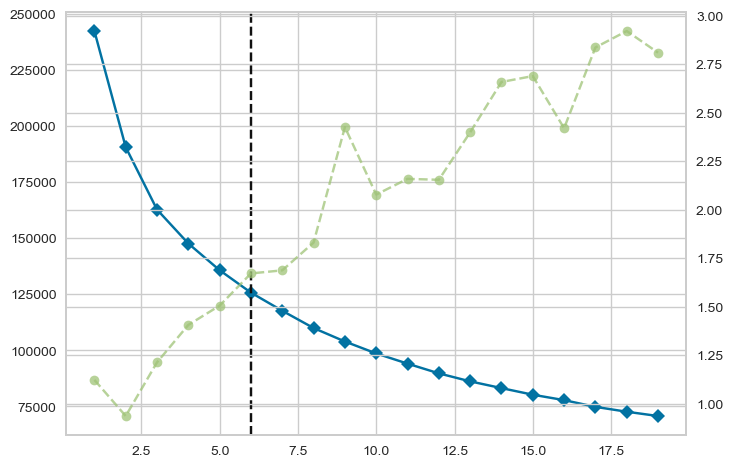

In [19]:
#scaling before modeling 
scaler = StandardScaler()
cc = scaler.fit_transform(concert_성악_)
#Elbow_method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))
visualizer.fit(cc)

In [20]:
# K-Means 모델 생성과 학습
model = KMeans(n_clusters=6, random_state=42, algorithm='auto')
clusters = model.fit(cc)
concert_성악['cluster'] = clusters.labels_

#####  < 교향곡 > 

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=19), k=(1, 20))

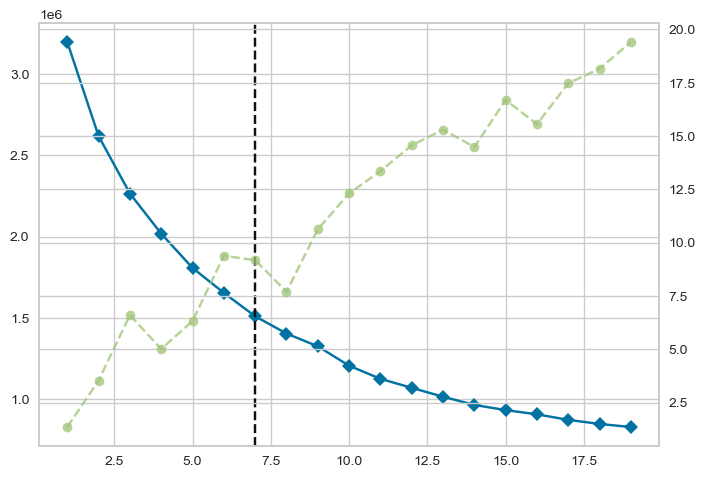

In [21]:
#scaling before modeling 
scaler = StandardScaler()
cc = scaler.fit_transform(concert_교향곡_)
#Elbow_method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))
visualizer.fit(cc)

In [22]:
# K-Means 모델 생성과 학습
model = KMeans(n_clusters=6, random_state=42, algorithm='auto')
clusters = model.fit(cc)
concert_교향곡['cluster'] = clusters.labels_

#####  < 독주 > 

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=19), k=(1, 20))

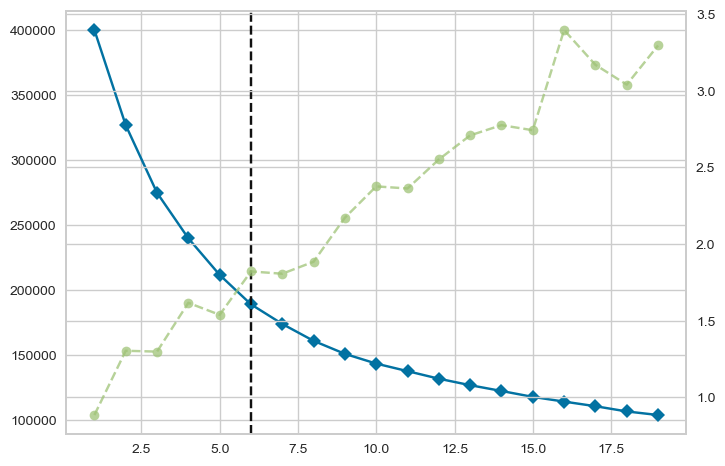

In [23]:
#scaling before modeling 
scaler = StandardScaler()
cc = scaler.fit_transform(concert_독주_)
#Elbow_method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))
visualizer.fit(cc)

In [24]:
# K-Means 모델 생성과 학습
model = KMeans(n_clusters=6, random_state=42, algorithm='auto')
clusters = model.fit(cc)
concert_독주['cluster'] = clusters.labels_

#####  < 콘서트 > 

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=19), k=(1, 20))

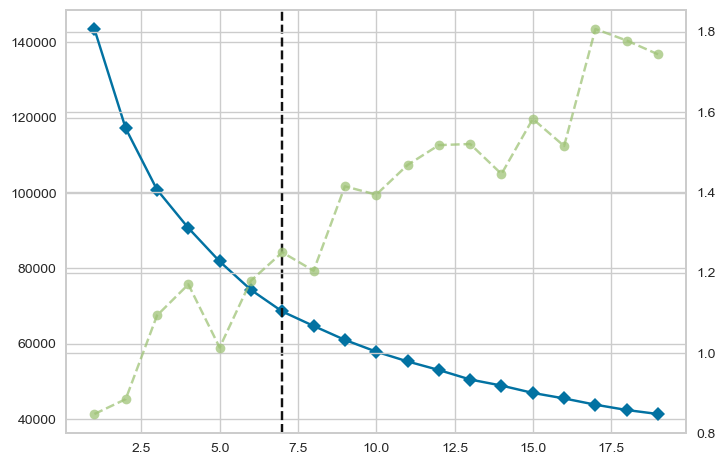

In [25]:
#scaling before modeling 
scaler = StandardScaler()
cc = scaler.fit_transform(concert_콘서트_)
#Elbow_method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))
visualizer.fit(cc)

In [26]:
# K-Means 모델 생성과 학습
model = KMeans(n_clusters=7, random_state=42, algorithm='auto')
clusters = model.fit(cc)
concert_콘서트['cluster'] = clusters.labels_

#####  < 합창 > 

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=19), k=(1, 20))

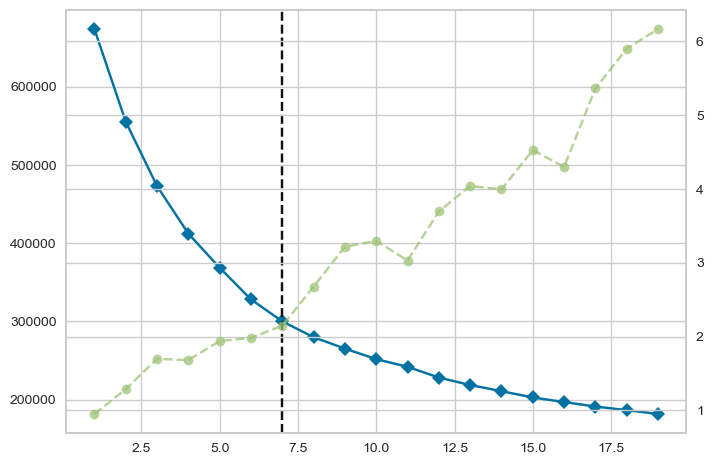

In [27]:
#scaling before modeling 
scaler = StandardScaler()
cc = scaler.fit_transform(concert_합창_)
#Elbow_method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))
visualizer.fit(cc)

In [28]:
# K-Means 모델 생성과 학습
model = KMeans(n_clusters=7, random_state=42, algorithm='auto')
clusters = model.fit(cc)
concert_합창['cluster'] = clusters.labels_

In [29]:
concert_합창.isnull().sum()

Unnamed: 0                0
age                   91763
gender                91711
membership_type_1     91711
membership_type_2     98297
membership_type_3    108457
membership_type_4    111681
membership_type_5    112291
membership_type_6    112297
tran_date                 0
tran_time                 0
play_date                 0
play_st_time              0
price                     0
ticket_cancel             0
discount_type             0
performance_code          0
pre_open_date             0
open_date                 0
genre                     0
place                     0
running_time              0
intermission              0
member_yn                 0
층                         0
자리번호                      0
블록(박스)                    0
열                      3972
sell_delta                0
seat                      0
discount                  0
ori_price                 0
seat_popularity           0
pre_popularity            0
popularity                0
cluster             

# To_CSV 

In [30]:
concert_성악.to_csv('data/concert_성악_code3.csv',index=False)
concert_교향곡.to_csv('data/concert_교향곡_code3.csv',index=False)
concert_독주.to_csv('data/concert_독주_code3.csv',index=False)
concert_콘서트.to_csv('data/concert_콘서트_code3.csv',index=False)
concert_합창.to_csv('data/concert_합창_code3.csv',index=False)

# Cluster 기반 자리 Mapping

**자리 Mapping 방법론** : 해당 장르의 특정 층, 특정 블럭 별로 각 클러스터의 행(자리번호)과 열에 대한 선호도 분포를 시각화한다. 
- 행 : 층,열 별 클러스터 선호도 분포 
- 열 : 자리번호 별 클러스터 선호도 분포 